# Importando bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Lendo dados

In [18]:
df = pd.read_csv('../data/processed/sample_df_processed.csv')
df['speed'] = df['speed'].astype('str')
df['feed'] = df['feed'].astype('str')

In [19]:
df.dtypes

vibration_x    float64
vibration_y    float64
vibration_z    float64
machine         object
operation       object
description     object
speed           object
feed            object
duration         int64
result           int64
dtype: object

# Separando dados em treino e teste

In [27]:
df_reduced, _ = train_test_split(
    df,
    train_size=50000,
    stratify=df["result"],
    random_state=42
)
# Reduzindo o dataset para conseguir executar o modelo selecionado

X = df_reduced.drop(columns=["result"])
y = df_reduced["result"]

# Separando o dataset em treino e teste mantendo a proporção das classes e com uma divisão de 70% para treino e 30% para teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Pre-processamento dos dados

In [28]:
# DIVISÃO ENTRE COLUNAS CATEGORICAS E NUMERICAS
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [29]:
# NORMALIZAR COLUNAS NUMERICAS
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# CODIFICAR COLUNAS CATEGORICAS
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [30]:
# PRE-PROCESSAMENTO DOS DADOS 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Criando pipeline utilizando preprocessamento dos dados e utilizando o algoritmo SMV

In [88]:
# CRIANDO O PIPELINE COM OS DADOS PRE-PROCESSADOS E O CLASSIFICADOR

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, class_weight='balanced'))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

## Criando matriz de confusão

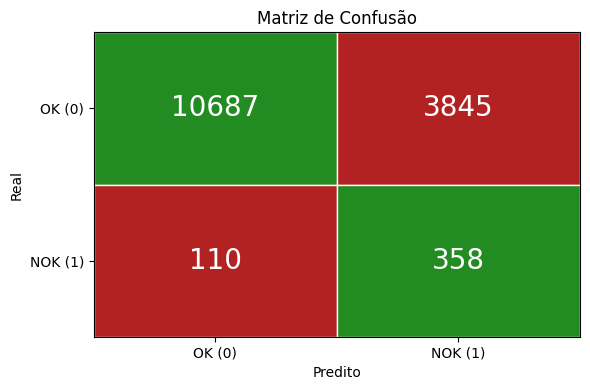

In [89]:
cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=1))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

1. Observa-se novamente o modelo classificando corretamente para casos OK
2. Para classe NOK com o balanceamento também houve um resultado satisfatorio.

## Avaliando métricas

In [75]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision recall f1-score
0            98.98  73.54    84.39
1             8.52  76.50    15.33
accuracy     73.63  73.63    73.63


Como esperando no relatório das métricas observamos:
1. A classe OK tem 98,98% das previsoes corretas. Recall de 73,54% o que mostra que a maioria dos casos ok foram detectados. Com resultados altos trazem um alto f1-score;
2. A classe NOK tem 8,52% de previsões corretas. Recall de 76,50% que mostra que o modelo ainda detecta muito pouco os casos nok. Como resultado desse equilibrio traz um f1-score baixo.
3. A acuracia tem um valor médio para alto devido ao desbalaceamento das classes.

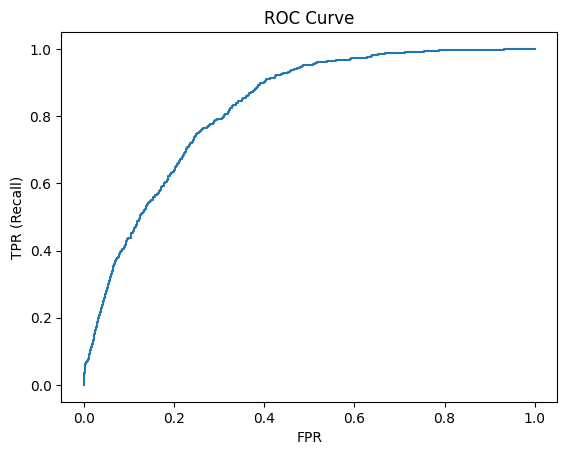

AUC: 0.83


In [36]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.show()
print(f"AUC: {auc:.2f}")



Pela curva ROC observamos:
1. Curva cresce suavemente o que mostra dificuldade na distribuição entre as classes
2. Valor maior que 0,5 (melhor que o acaso) mas abaixo do ideal (0,9)
3. Torna o modelo aceitavel mas ainda com pontos de melhoria 

# Otimizar resultado a partir da curva ROC

## Otimização F1-score

In [83]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_threshold_f1 = thresholds_pr[np.argmax(f1)]

print(f"Threshold ideal (F1-score máximo): {optimal_threshold_f1:.4f}")

Threshold ideal (F1-score máximo): 0.0970


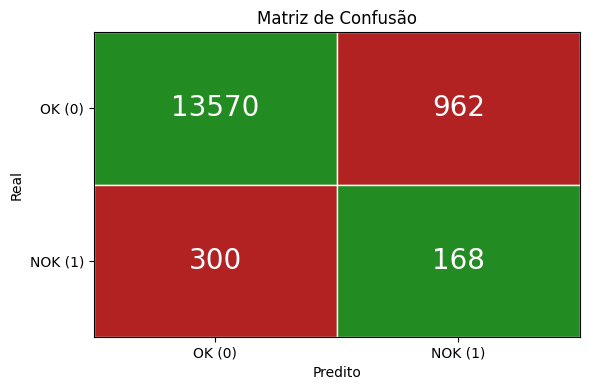

In [85]:
y_pred = (y_proba >= optimal_threshold_f1).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

# Plotar manualmente com cores nos quadrantes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=1))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

# Eixos e rótulos
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

# Ajustes de grade
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [79]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision recall f1-score
0            97.84  93.38    95.56
1            14.87  35.90    21.03
accuracy     91.59  91.59    91.59


1. Após otimizar visando uma melhora no f1-score observa-se que para os casos de NOK houve um aumento na precisão e uma queda no recall e um aumento obvio no f1-score;
2. Para os casos OK a precisão teve uma queda bem baixa, o recall aumento significativamente e também uma boa melhora no f1-score;
3. Quanto ao resultados gerais as três métricas houveram um aumento.

## Otimização Youden

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]
print(f"Threshold ideal (Youden): {optimal_threshold:.4f}")


Threshold ideal (Youden): 0.0168


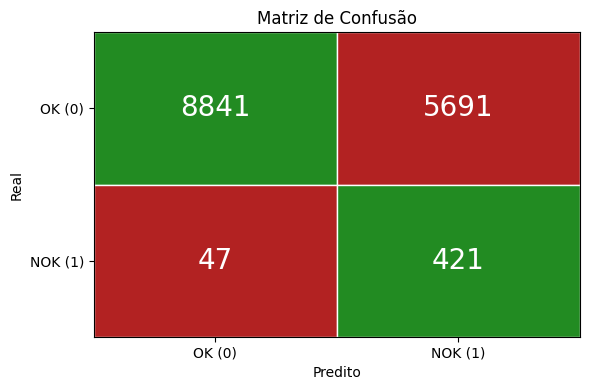

In [86]:
y_pred = (y_proba >= optimal_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ["OK (0)", "NOK (1)"]

fig, ax = plt.subplots(figsize=(6, 4))

# Plotar manualmente com cores nos quadrantes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = '#228B22' if i == j else '#B22222'
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, facecolor=color, edgecolor='white', linewidth=1))
        ax.text(j + 0.5, i + 0.5, str(value), ha='center', va='center', color='white', fontsize=20)

# Eixos e rótulos
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(labels)
ax.set_xlabel("Predito")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusão")

# Ajustes de grade
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [82]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df_formatted = report_df.head(3).map(lambda x: f"{x * 100:.2f}")
print(report_df_formatted)

         precision recall f1-score
0            99.47  60.84    75.50
1             6.89  89.96    12.80
accuracy     61.75  61.75    61.75


1. Após otimizar o ponto de mudança dessa maneira observa-se uma melhoria no recall dos casos NOK mas uma piora tanto no F1-Score quanto precisão;
2. O recall e o f1-sscore dos casos OK cai muito devido a otimização utilizada;
3. A acurácia geral também diminui devido ao desbalanceamento para casos OK.